# FIS Project 2 - Multigrid

#### Filiz Günal - 431174

In [12]:
import numpy as np
import matplotlib.pyplot as plt

### Part 1: Gauss-Seidel Relaxation with lexicographical ordering (GS-LEX)

In [13]:
def GaussSeidelLEX(u_0, f, v):
    N = np.size(f, 1) - 1
    h = 1 / N

    # Define a helper function to calculate the update for a single grid point
    def update_point(i, j):
        return 0.25 * ((h ** 2) * f[i, j] + u_0[i - 1, j] + u_0[i + 1, j] + u_0[i, j - 1] + u_0[i, j + 1])

    # Perform the Gauss-Seidel iterations
    for _ in range(v):
        for i in range(1, N):
            for j in range(1, N):
                u_0[i, j] = update_point(i, j)

    return u_0


### Part 2: Restriction Operator

In [14]:
def restriction(r):
    
    N=np.size(r,1)-1 # for fine mesh
    N_c=N//2 # for coarse mesh 
    fij=np.zeros((N_c+1,N_c+1))
    
    for i in range(1,N_c):
        ii=2*i
        for j in range(1,N_c):
            jj=2*j
            fij[i,j]=1/16*(r[ii-1,jj-1]+2*r[ii,jj-1]+r[ii+1,jj-1]+2*r[ii-1,jj]+4*r[ii,jj]+2*r[ii+1,jj]+r[ii-1,jj+1]+2*r[ii,j+1]+r[ii+1,jj+1])
    return fij


### Part 2: Prolongation Operator

In [15]:
def prolongation(uc):
    # Get the dimensions of the input array
    Nc = uc.shape[0] - 1
    N = 2 * Nc
    
    # Initialize the output array with zeros
    uf = np.zeros((N + 1, N + 1))
    
    # Perform vectorized operations for each (i, j) in the input array
    for i in range(1, Nc):
        for j in range(1, Nc):
            # Calculate the corresponding indices in the output array
            ii=2*i
            jj=2*j
            
            # Prolongation: Add the value at (i, j) to corresponding locations in the output array
            uf[ii,jj]+=uc[i,j]
            
            uf[ii-1,jj]+=0.5*uc[i,j]
            uf[ii+1,jj]+=0.5*uc[i,j]
            uf[ii,jj-1]+=0.5*uc[i,j]
            uf[ii,jj+1]+=0.5*uc[i,j]
            
            uf[ii-1,jj-1]+=0.25*uc[i,j]
            uf[ii+1,jj-1]+=0.25*uc[i,j]
            uf[ii-1,jj+1]+=0.25*uc[i,j]
            uf[ii+1,jj+1]+=0.25*uc[i,j]
    
    return uf

def res(u,f):
    N=np.size(f,0)-1
    h=1/N
    r=np.zeros((N+1,N+1))
    for i in range(1,N):
        for j in range(1,N):
            r[i,j]=f[i,j]+(u[i-1,j]-2*u[i,j]+u[i+1,j]+u[i,j-1]-2*u[i,j]+u[i,j+1])/(h**2)
            
    return r


def norm(matrix):
    rowsum = np.abs(matrix).sum(axis=1)
    norm = rowsum.max()
    return norm

def MG(l,u,f,g,v1,v2):
    u=GaussSeidelLEX(u,f,v1)
    rl=res(u,f)
    rl1=restriction(rl)
    if l==1:
        el1=np.zeros((np.size(rl1,1),np.size(rl1,1)))
        el1=GaussSeidelLEX(el1,-rl1,1)
    else:
        el1=np.zeros((np.size(rl1,1),np.size(rl1,1)))
        for j in range(1,g+1):
            el1=MG(l-1,el1,-rl1,g,v1,v2)
    el=prolongation(el1)
    u=GaussSeidelLEX(u-el,f,v2)
    return u

#### Function to use for test cases n=4 and n=7

In [52]:
def multigrid_convergence(n):
    N = 2**n
    h = 1 / N
    Nc = N // 2
    x = np.linspace(0, 1, N + 1)
    y = np.linspace(0, 1, N + 1)
    f = np.zeros((N + 1, N + 1))
    u_s = np.zeros((N + 1, N + 1))

    # Precompute constant values
    pi2 = 2 * np.pi
    sin_pi2_x = np.sin(pi2 * x)
    sin_pi2_y = np.sin(pi2 * y)

    for i in range(N + 1):
        for j in range(N + 1):
            f[i, j] = 8 * np.pi**2 * sin_pi2_x[i] * sin_pi2_y[j]
            u_s[i, j] = sin_pi2_x[i] * sin_pi2_y[j]

    l = n
    nr0 = norm(res(np.zeros((N + 1, N + 1)), f))
    
    tol = 1
    re1 = [1]
    re2 = [1]
    um1 = np.zeros((N + 1, N + 1))
    um2 = np.zeros((N + 1, N + 1))

    for m in range(1, 20):
        um1 = MG(l, um1, f, 2, 1, 1)
        um2 = MG(l, um2, f, 2, 2, 1)

        tol1 = (norm(res(um1, f))) / nr0
        tol2 = (norm(res(um2, f))) / nr0

        re1.append(tol1)
        re2.append(tol2)

    x1 = np.arange(20)
    plt.grid(True, which="both")
    plt.semilogy(x1, re1, label='$v_1=v_2=1$')
    plt.semilogy(x1, re2, label='$v_1=2 , v_2=1$')
    plt.xlim([0, m])
    plt.title(f'Convergence for the Multigrid Iteration when (n={n})')
    plt.xlabel('Number of Iterations')
    plt.ylabel('$  ||r^m||_\infty / ||r^0||_\infty $')
    plt.legend()
    plt.show()



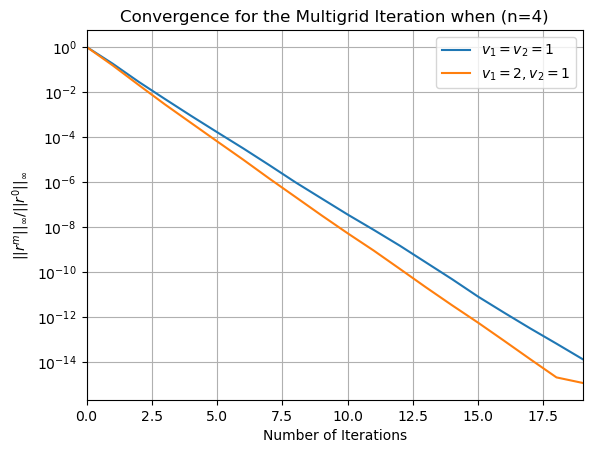

In [53]:
# Run for n=4
multigrid_convergence(4)

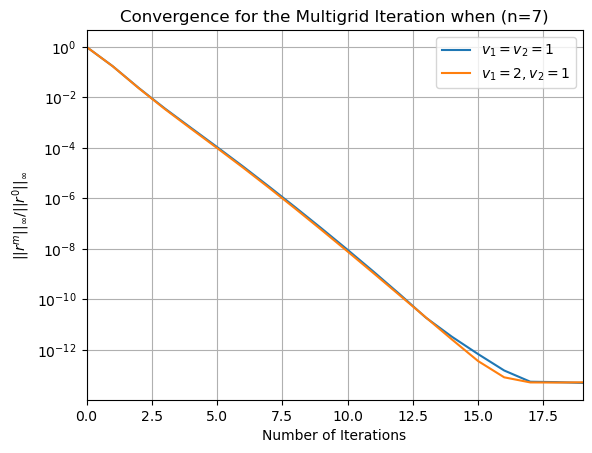

In [54]:
# Run for n=7
multigrid_convergence(7)